# Generate Probability of Detection for Operators
Code author: Sahar H. El Abbadi
Date started: 2022-02-23
Date last edited: 2022-02-27

In [1]:
# Setup

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_manipulation_methods import load_clean_data, load_meter_data, apply_qc_filter

# Load clean operator data
# format for naming: [operator]_stage

cm_1, cm_2, ghg_1, ghg_2, kairos_1_ls23, kairos_1_ls25, kairos_2_ls23, kairos_2_ls25, kairos_3_ls23, kairos_3_ls25 = load_clean_data()

# Load meter data
# cm_meter = metered data for Carbon Mapper overpasses
# ghg_meter = metered data for GHGSat overpasses
# kairos_meter = metered data for Kairos overpasses

cm_meter, ghg_meter, kairos_meter = load_meter_data()

   bin_median  detection_prob_mean  detection_prob_two_sigma_upper  \
0         2.5                  0.0                             0.0   
1         7.5                  0.0                             0.0   
2        12.5                  1.0                             0.0   
3        17.5                  1.0                             0.0   
4        22.5                  1.0                             0.0   

   detection_prob_two_sigma_lower  n_data_points  n_detected  
0                             0.0              1           0  
1                             0.0              2           0  
2                             0.0              2           2  
3                             0.0              1           1  
4                             0.0              4           4  


/Users/sea/PycharmProjects/CRF22_Airplanes/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/sea/PycharmProjects/CRF22_Airplanes/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0.5, 1.0, 'Carbon Mapper Probability of Detection - Stage 1')

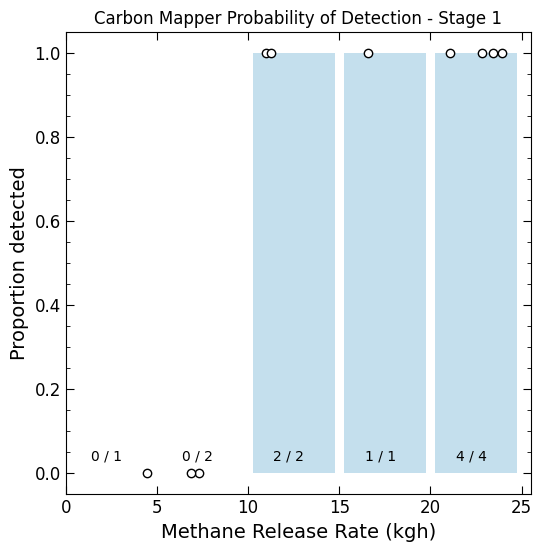

In [2]:
# Carbon Mapper probability of detection

n_bins = 5 # number of bins
threshold = 25 # highest release rate in kgh to show in detection threshold graph

# merge meter and operator reports and apply Stanford QC filter
cm_df = apply_qc_filter(cm_1, cm_meter)

# Make column with easier name for coding for now.
cm_df['release_rate_kgh'] = cm_df['Last 60s (kg/h) - from Stanford']


# Determine whether each overpass below the threshold value was detected
cm_detection = pd.DataFrame()
cm_detection['overpass_id'] = cm_df.PerformerExperimentID
cm_detection['non_zero_release'] = cm_df.release_rate_kgh!=0 # True if we conducted a release
cm_detection['operator_detected'] = cm_df.Detected
cm_detection['release_rate_kgh'] = cm_df.release_rate_kgh

# Select overpasses where
# Select overpasses that are below the threshold of interest AND where release is non-zero
cm_detection = cm_detection.loc[cm_detection.release_rate_kgh <= threshold].loc[cm_detection.non_zero_release == True]

# Create bins for plot
bins = np.linspace(0, threshold, n_bins+1)
detection_probability = np.zeros(n_bins)

# These variables are for keeping track of values as I iterate through the bins in the for loop below:
bin_size, bin_num_detected = np.zeros(n_bins).astype('int'), np.zeros(n_bins).astype('int')
bin_median = np.zeros(n_bins)
bin_two_sigma = np.zeros(n_bins)
two_sigma_upper, two_sigma_lower = np.zeros(n_bins), np.zeros(n_bins)

# For each bin, find number of data points and detection probability

for i in range(n_bins):

    # Set boundary of bin
    bin_min = bins[i]
    bin_max = bins[i+1]
    bin_median[i] = (bin_min+bin_max)/2

    # Select data within the bin range
    binned_data = cm_detection.loc[cm_detection.release_rate_kgh < bin_max].loc[cm_detection.release_rate_kgh>=bin_min]

    # Count the total number of overpasses detected within each bin
    bin_num_detected[i] = binned_data.operator_detected.sum()

    n = len(binned_data)
    bin_size[i] = n # this is the y-value for the bin in the plot
    p = binned_data.operator_detected.sum()/binned_data.shape[0] #df.shape[0] gives number of rows
    detection_probability[i] = p

    # Standard Deviation of a binomial distribution
    sigma = np.sqrt(p*(1-p)/n)
    bin_two_sigma[i] = 2*sigma

    # Find the lower and upper bound defined by two sigma
    two_sigma_lower[i] = 2*sigma
    two_sigma_upper[i] = 2*sigma
    if 2*sigma + p > 1:
        two_sigma_upper[i] = 1-p # probability cannot exceed 1
    if p - 2*sigma < 0 :
        two_sigma_lower[i] = p # if error bar includes zero, set lower bound to p?


detection_prob = pd.DataFrame({
    "bin_median": bin_median,
    "detection_prob_mean": detection_probability,
    "detection_prob_two_sigma_upper": two_sigma_upper,
    "detection_prob_two_sigma_lower": two_sigma_lower,
    "n_data_points": bin_size,
    "n_detected": bin_num_detected})

print(detection_prob)
# Function will output cm_detection and detection_prob

detection_plot = detection_prob.copy()
fig, ax = plt.subplots(1, figsize=(6, 6))

# Set bin width:
w = threshold/n_bins/2.5

# Use n_bins set above
for i in range(n_bins):
    ax.annotate(f'{detection_plot.n_detected[i]} / {detection_plot.n_data_points[i]}', [detection_plot.bin_median[i]-w/1.8, 0.03], fontsize=10)

# for plotting purpose, we don't want a small hyphen indicating zero uncertainty interval
detection_plot.loc[detection_plot['detection_prob_two_sigma_lower'] == 0, 'detection_prob_two_sigma_lower']=np.nan
detection_plot.loc[detection_plot.detection_prob_two_sigma_upper == 0, 'detection_prob_two_sigma_upper']=np.nan
detection_plot.loc[detection_plot.detection_prob_mean == 0, 'detection_prob_mean']=np.nan

# Plot bars and detection points
ax.bar(detection_plot.bin_median,
       detection_plot.detection_prob_mean,
       yerr=[detection_plot.detection_prob_two_sigma_lower, detection_plot.detection_prob_two_sigma_upper],
       error_kw=dict(lw=2, capsize=3, capthick=1,alpha=0.3),
       width=threshold/n_bins-0.5,alpha=0.6,color='#9ecae1',ecolor='black', capsize=2)

# yulia's color: edgecolor="black",facecolors='none'
ax.scatter(cm_detection.release_rate_kgh,np.multiply(cm_detection.operator_detected,1),
           facecolors='white',
           edgecolors='black')

# Add more room on top and bottom
ax.set_ylim([-0.05,1.05])
ax.set_xlim([0,threshold + 0.5])

# Axes formatting and labels
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=11)
ax.set_xlabel('Methane Release Rate (kgh)',fontsize=14)
ax.set_ylabel('Proportion detected',fontsize=14)
ax.tick_params(direction='in', right=True, top=True)
ax.tick_params(labelsize=12)
ax.minorticks_on()
ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
ax.tick_params(direction='in', which='minor', length=3, bottom=False, top=False, left=True, right=True)
ax.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)

# Set axes and background color to white
ax.set_facecolor('white')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.title('Carbon Mapper Probability of Detection - Stage 1')


In [3]:
print(binned_data)

    overpass_id  non_zero_release  operator_detected  release_rate_kgh
18         19.0              True               True         23.913846
34         35.0              True               True         21.052807
56         57.0              True               True         23.432405
57         58.0              True               True         22.844824


   bin_median  detection_prob_mean  detection_prob_two_sigma_upper  \
0         2.5                  1.0                             0.0   
1         7.5                  1.0                             0.0   
2        12.5                  0.5                             0.5   
3        17.5                  NaN                             NaN   
4        22.5                  1.0                             0.0   

   detection_prob_two_sigma_lower  n_data_points  n_detected  
0                             0.0              1           1  
1                             0.0              1           1  
2                             0.5              2           1  
3                             NaN              0           0  
4                             0.0              2           2  


/var/folders/vp/7kbksk9n5bqdsc5w00b6k5zr0000gn/T/ipykernel_14716/1919394929.py:51: RuntimeWarning: invalid value encountered in scalar divide
  p = binned_data.operator_detected.sum()/binned_data.shape[0] #df.shape[0] gives number of rows


Text(0.5, 1.0, 'GHGSat Probability of Detection - Stage 1')

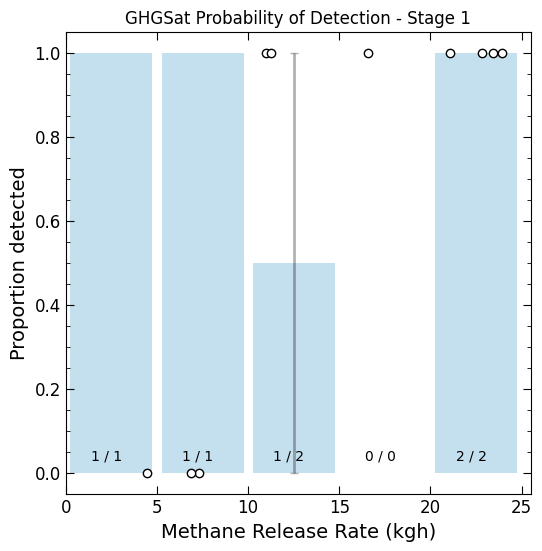

In [4]:
# GHGSat probability of detection

n_bins = 5 # number of bins
threshold = 25 # highest release rate in kgh to show in detection threshold graph

# merge meter and operator reports and apply Stanford QC filter
ghgsat_df = apply_qc_filter(ghg_1, ghg_meter)

# Make column with easier name for coding for now.
ghgsat_df['release_rate_kgh'] = cm_df['Last 60s (kg/h) - from Stanford']


# Determine whether each overpass below the threshold value was detected
ghg_detection = pd.DataFrame()
ghg_detection['overpass_id'] = ghgsat_df.PerformerExperimentID
ghg_detection['non_zero_release'] = ghgsat_df.release_rate_kgh!=0 # True if we conducted a release
ghg_detection['operator_detected'] = ghgsat_df.Detected
ghg_detection['release_rate_kgh'] = ghgsat_df.release_rate_kgh

# Select overpasses where
# Select overpasses that are below the threshold of interest AND where release is non-zero
ghg_detection = ghg_detection.loc[ghg_detection.release_rate_kgh <= threshold].loc[ghg_detection.non_zero_release == True]

# Create bins for plot
bins = np.linspace(0, threshold, n_bins+1)
detection_probability = np.zeros(n_bins)

# These variables are for keeping track of values as I iterate through the bins in the for loop below:
bin_size, bin_num_detected = np.zeros(n_bins).astype('int'), np.zeros(n_bins).astype('int')
bin_median = np.zeros(n_bins)
bin_two_sigma = np.zeros(n_bins)
two_sigma_upper, two_sigma_lower = np.zeros(n_bins), np.zeros(n_bins)

# For each bin, find number of data points and detection probability

for i in range(n_bins):

    # Set boundary of bin
    bin_min = bins[i]
    bin_max = bins[i+1]
    bin_median[i] = (bin_min+bin_max)/2

    # Select data within the bin range
    binned_data = ghg_detection.loc[ghg_detection.release_rate_kgh < bin_max].loc[ghg_detection.release_rate_kgh>=bin_min]

    # Count the total number of overpasses detected within each bin
    bin_num_detected[i] = binned_data.operator_detected.sum()

    n = len(binned_data)
    bin_size[i] = n # this is the y-value for the bin in the plot
    p = binned_data.operator_detected.sum()/binned_data.shape[0] #df.shape[0] gives number of rows
    detection_probability[i] = p

    # Standard Deviation of a binomial distribution
    sigma = np.sqrt(p*(1-p)/n)
    bin_two_sigma[i] = 2*sigma

    # Find the lower and upper bound defined by two sigma
    two_sigma_lower[i] = 2*sigma
    two_sigma_upper[i] = 2*sigma
    if 2*sigma + p > 1:
        two_sigma_upper[i] = 1-p # probability cannot exceed 1
    if p - 2*sigma < 0 :
        two_sigma_lower[i] = p # if error bar includes zero, set lower bound to p?


detection_prob = pd.DataFrame({
    "bin_median": bin_median,
    "detection_prob_mean": detection_probability,
    "detection_prob_two_sigma_upper": two_sigma_upper,
    "detection_prob_two_sigma_lower": two_sigma_lower,
    "n_data_points": bin_size,
    "n_detected": bin_num_detected})

print(detection_prob)
# Function will output cm_detection and detection_prob

detection_plot = detection_prob.copy()
fig, ax = plt.subplots(1, figsize=(6, 6))

# Set bin width:
w = threshold/n_bins/2.5

# Use n_bins set above
for i in range(n_bins):
    ax.annotate(f'{detection_plot.n_detected[i]} / {detection_plot.n_data_points[i]}', [detection_plot.bin_median[i]-w/1.8, 0.03], fontsize=10)

# for plotting purpose, we don't want a small hyphen indicating zero uncertainty interval
detection_plot.loc[detection_plot['detection_prob_two_sigma_lower'] == 0, 'detection_prob_two_sigma_lower']=np.nan
detection_plot.loc[detection_plot.detection_prob_two_sigma_upper == 0, 'detection_prob_two_sigma_upper']=np.nan
detection_plot.loc[detection_plot.detection_prob_mean == 0, 'detection_prob_mean']=np.nan

# Plot bars and detection points
ax.bar(detection_plot.bin_median,
       detection_plot.detection_prob_mean,
       yerr=[detection_plot.detection_prob_two_sigma_lower, detection_plot.detection_prob_two_sigma_upper],
       error_kw=dict(lw=2, capsize=3, capthick=1,alpha=0.3),
       width=threshold/n_bins-0.5,alpha=0.6,color='#9ecae1',ecolor='black', capsize=2)

# yulia's color: edgecolor="black",facecolors='none'
ax.scatter(cm_detection.release_rate_kgh,np.multiply(cm_detection.operator_detected,1),
           facecolors='white',
           edgecolors='black')

# Add more room on top and bottom
ax.set_ylim([-0.05,1.05])
ax.set_xlim([0,threshold + 0.5])

# Axes formatting and labels
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=11)
ax.set_xlabel('Methane Release Rate (kgh)',fontsize=14)
ax.set_ylabel('Proportion detected',fontsize=14)
ax.tick_params(direction='in', right=True, top=True)
ax.tick_params(labelsize=12)
ax.minorticks_on()
ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
ax.tick_params(direction='in', which='minor', length=3, bottom=False, top=False, left=True, right=True)
ax.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)

# Set axes and background color to white
ax.set_facecolor('white')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.title('GHGSat Probability of Detection - Stage 1')

In [5]:
print(binned_data)

    overpass_id  non_zero_release  operator_detected  release_rate_kgh
56         57.0              True               True         23.432405
57         58.0              True               True         22.844824


In [6]:
print(ghg_detection.dtypes)

overpass_id          float64
non_zero_release        bool
operator_detected       bool
release_rate_kgh     float64
dtype: object


In [7]:
print(ghg_detection)

    overpass_id  non_zero_release  operator_detected  release_rate_kgh
0           1.0              True               True         10.968637
1           2.0              True               True          7.314810
3           4.0              True               True          4.461038
54         55.0              True              False         11.262255
56         57.0              True               True         23.432405
57         58.0              True               True         22.844824
